In [1]:
print('''
This module is working but currently the first connection times on the
FDSN server are wrong and have not yet been corrected. While the database
gets updated, you can use the stationcount-20191109.ipynb notebook.
''')


This module is working but currently the first connection times on the
FDSN server are wrong and have not yet been corrected. While the database
gets updated, you can use the stationcount-20191109.ipynb notebook.



In [2]:
from obspy import read_inventory
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

In [3]:
# set data start/end times
fmt = '%Y-%m-%dT%H:%M:%S'.replace(':','%%3A')
start = UTCDateTime(2016, 12, 1, 0, 0, 0).datetime # (YYYY, m, d, H, M, S)
end = UTCDateTime.now().datetime # (YYYY, m, d, H, M, S)
s = start.strftime(fmt)
e = end.strftime(fmt)

# set channels (comma separated list)
ch = 'EHZ,SHZ'.replace(',', '%2C')

# get inventory
query = 'https://fdsnws.raspberryshakedata.com/fdsnws/station/1/query?network=AM&station=*&location=00&channel=%s&nodata=404' % (ch)
print('Downloading inventory from:\n%s' % query)
inv = read_inventory(query)


https://fdsnws.raspberryshakedata.com/fdsnws/station/1/query?network=AM&station=*&location=00&channel=EHZ%2CSHZ&nodata=404


In [4]:
n = 0
x = []
d = {}
for sta in inv[0]:
    d[sta.code] = sta.start_date.datetime
for sta in inv[0]:
    if d[sta.code] > sta.start_date.datetime:
        d[sta.code] = sta.start_date.datetime
        n += 1

for s in d:
    x.append(d[s])
x.sort()

time, stationcount = [], []
c = 1
for s in x:
    stationcount.append(c)
    time.append(s)
    
    c += 1

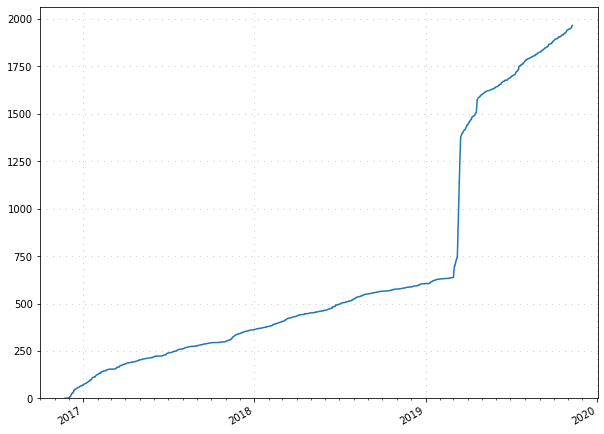

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(time, stationcount)

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter(fmt)
plt.grid(b=True, which='major', axis='both', dashes=(1,7))
plt.ylim(0,None)
fig.autofmt_xdate()


In [6]:
xx = []
e = {}
for sta in inv[0]:
    e[sta.code] = sta.start_date.datetime
for sta in inv[0]:
    if e[sta.code] > sta.start_date.datetime:
        e[sta.code] = sta.start_date.datetime
        n += 1

for sta in inv[0]:
    if sta.is_active(starttime=end-timedelta(days=14)):
        pass
    else:
        try:
            del e[sta.code]
        except:
            pass

for s in e:
    xx.append(e[s])
xx.sort()

timee, stationcounte = [], []
c = 1
for s in xx:
    stationcounte.append(c)
    timee.append(s)
    c += 1

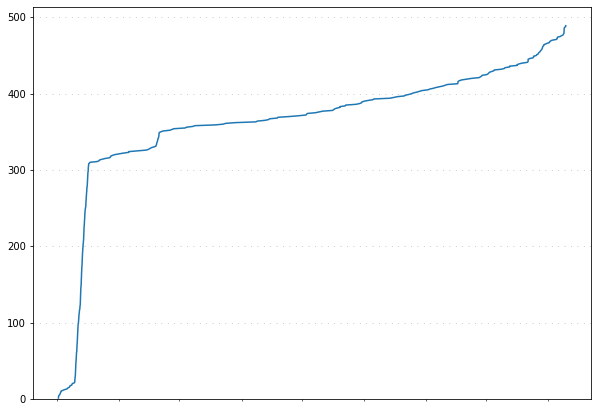

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(timee, stationcounte)

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter(fmt)
plt.grid(b=True, which='major', axis='both', dashes=(1,7))
plt.ylim(0,None)
fig.autofmt_xdate()
